In [1]:
!nvidia-smi

Thu Apr 15 08:37:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install fastbook

     |████████████████████████████████| 727kB 17.7MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 194kB 54.5MB/s 
     |████████████████████████████████| 1.2MB 40.2MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 12.8MB 223kB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
from fastai.vision.all import *
import gc

In [4]:
gc.collect()
path = untar_data(URLs.IMAGENETTE)

In [8]:
def get_dls(path, size=224, bs = 64):
  dblock = DataBlock(blocks=(ImageBlock,CategoryBlock), 
          get_items = get_image_files,
          get_y = parent_label,
          item_tfms = Resize(size),
          batch_tfms = [#*aug_transforms(min_scale=0.75,size=size), 
                        Normalize.from_stats(*imagenet_stats)] )
  dls = dblock.dataloaders(path, bs=bs)
  return dls

In [9]:
dls = get_dls(path, size = 128, bs = 64)

In [24]:
model = xresnet34()
loss = CrossEntropyLossFlat()
learn = Learner(dls, model = model, loss_func=loss, metrics=accuracy)
learn.fit_one_cycle(5,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.907094,1.477755,0.515310,01:22
1,1.044081,0.995798,0.685960,01:20
2,0.770344,0.832220,0.746079,01:20
3,0.611988,0.637576,0.795743,01:21
4,0.457843,0.577013,0.817774,01:22


### Testing crop into square for a single image.

Aim is to crop one validation image into 4 corners and do valid on that, take mean of the metrics.
Do one with center as well.

In [43]:
x,y = dls.one_batch()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


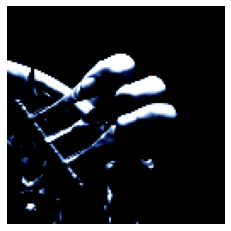

In [44]:
show_image(x[60])

In [50]:
a,b,c = x[60].size()
a

3

In [12]:
image = x[60]
dimension = image.shape[1]
redu50 = int(dimension/2)
image.shape
# first channel is RGB

torch.Size([3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


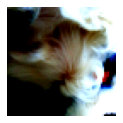

In [13]:
show_image(image[:,:redu50,:redu50])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


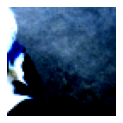

In [14]:
show_image(image[:,:redu50,redu50:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


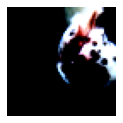

In [15]:
show_image(image[:,redu50:,:redu50])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


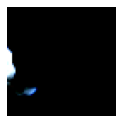

In [16]:
show_image(image[:,redu50:,redu50:])

In [17]:
corners = image[:,:redu50,:redu50], image[:,:redu50,redu50:], image[:,redu50:,:redu50], image[:,redu50:,redu50:]

In [18]:
redu25 = int(dimension/4)
redu75 = int(dimension*3/4)
redu25,redu75

(32, 96)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


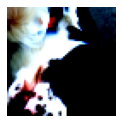

In [19]:
show_image(image[:,redu25:redu75,redu25:redu75])

In [20]:
center = image[:,redu25:redu75,redu25:redu75]

### Creating a function that retuns the corners and center

In [21]:
x = "hello"
#if condition returns False, AssertionError is raised:
assert x == "hello", "x should be 'hello'"

In [22]:
def get_corners_center(image):
  dimension_x = image.shape[1] # since same dimension
  dimension_y = image.shape[2]
  assert dimension_x == dimension_y, 'dimensions of the image are not equal {}, {}'.format(dimension_x,dimension_y)
  dimension = image.shape[1]
  redu25 = int(dimension/4)
  redu50 = int(dimension/2)
  redu75 = int(dimension*3/4)
  center = image[:,redu25:redu75,redu25:redu75]
  corners = image[:,:redu50,:redu50], image[:,:redu50,redu50:], image[:,redu50:,:redu50], image[:,redu50:,redu50:]
  return corners, center

In [23]:
corners, center = get_corners_center(image)

Defining the TTA_mod function to handle the cropping call and the valid check.

In [32]:
EnvironmentError.errno

<member 'errno' of 'OSError' objects>

In [114]:
class ImagePart(Transform):
    def __init__(self, section):
        self.section = section 

    def encodes(self, x:TensorImage):
        # image2tensor(img.resize(torch.Size([size,size])))
        #print(x.size())
        _, _, dimension_x, dimension_y = x.size()
        #assert dimension_x == dimension_y, 'dimensions of the image are not equal {}, {}'.format(dimension_x,dimension_y)
        #print(w,h)
        redu25x = int(dimension_x/4)
        redu50x = int(dimension_x/2)
        redu75x = int(dimension_x*3/4)
        redu25y = int(dimension_y/4)
        redu50y = int(dimension_y/2)
        redu75y = int(dimension_y*3/4)
        try :
          if self.section == 'center':
            x = x[:,:,redu25x:redu75x,redu25y:redu75y]
          if self.section == 'corner1':
            x = x[:,:,:redu50x,:redu50y]
          if self.section == 'corner2':
            x = x[:,:,:redu50x,redu50y:]
          if self.section == 'corner3':
            x=  x[:,:,redu50x:,:redu50y]
          if self.section == 'corner4':
            x = x[:,:,redu50x:,redu50y:]
          #print(x.size())
          return x
        except ValueError:
          print('{} not in allowed section types.'.format(self.section))
        

def TTA_mod(learn, dl,sections): 
    """
    in fastai method, learn.tta is being called. so tta takes learner.
    """
    tfms = [ImagePart(s) for s in sections]
    tta_preds = []
    tta_targs = []
    for tfm in tfms:
        dl = dl.new(after_batch=Pipeline([IntToFloatTensor, tfm]))
        p, t = learn.get_preds(dl=dl, inner=True)
        tta_preds.append(p)
        tta_targs.append(t)         
    tta_preds = torch.cat(tta_preds)#.mean(0)
    tta_targs = torch.cat(tta_targs)#.view[-1,len(sections)] # since targs will repeat 
    return tta_preds, tta_targs

In [115]:
dl = learn.dls.valid
sections = ['center', 'corner1', 'corner2' , 'corner3' , 'corner4'] 
tfms = [ImagePart(s) for s in sections]

In [116]:
tfms

[ImagePart:
 encodes: (TensorImage,object) -> encodes
 decodes: , ImagePart:
 encodes: (TensorImage,object) -> encodes
 decodes: , ImagePart:
 encodes: (TensorImage,object) -> encodes
 decodes: , ImagePart:
 encodes: (TensorImage,object) -> encodes
 decodes: , ImagePart:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

In [117]:
tta_preds=[]

In [118]:
tfm = tfms[0]
dl = dl.new(after_batch=Pipeline([IntToFloatTensor, tfm]))

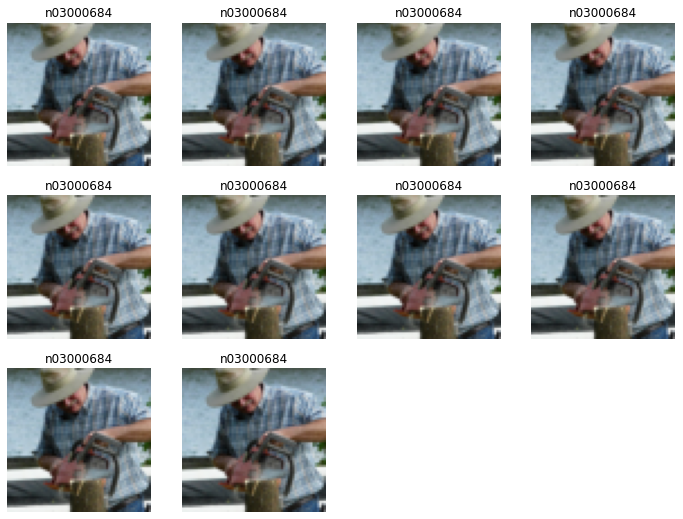

In [121]:
dl.show_batch(max_n=10,unique=True)

In [92]:
a,b = learn.get_preds(dl=dl, inner=True)

In [111]:
a[0].shape

torch.Size([1000])

In [103]:
sections = ['center', 'corner1'] #, 'corner2' , 'corner3' , 'corner4'] # sections to use of the valid set
preds, targs = TTA_mod(learn, learn.dls.valid, sections)

In [101]:
targs.view(-1, len(sections))[:,0]

TensorCategory([3, 6, 9,  ..., 6, 8, 3])

In [104]:
preds.size(),targs.size()

(torch.Size([5356, 1000]), torch.Size([5356]))

In [107]:
accuracy(preds[:][0],targs)

AssertionError: ignored

### With fastai TTA

In [ ]:
def get_dls(path, size=224, bs = 64):
  dblock = DataBlock(blocks=(ImageBlock,CategoryBlock), 
          get_items = get_image_files,
          get_y = parent_label,
          item_tfms = Resize(size),
          batch_tfms = [#*aug_transforms(min_scale=0.75,size=size), 
                        Normalize.from_stats(*imagenet_stats)] )
  dls = dblock.dataloaders(path, bs=bs)
  return dls

In [ ]:
dls = get_dls(path,size = 128, bs =64)
x,y = dls.one_batch()

In [ ]:
model = xresnet34()
loss = CrossEntropyLossFlat()
learn = Learner(dls, model = model, loss_func=loss, metrics=accuracy)
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.384815,2.055215,0.473114,01:43
1,0.854001,0.795118,0.747573,01:42


In [ ]:
preds,targs = learn.tta(n=4)

In [ ]:
learn.loss_func(preds,targs).item(), accuracy(preds,targs).item()

(6.2899909019470215, 0.74607914686203)